# scqubits example: Parameter sweeps
J. Koch and P. Groszkowski

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

---

In [5]:
import scqubits as scq
from scqubits import HilbertSpace, ParameterSweep

import numpy as np

Composite Hilbert spaces, as defined by `HilbertSpace` objects, are more complicated than individual qubits. A variety of parameter sweeps can be considered, including multi-dimensional sweeps over a collection of parameters. A parameter to be varied does not need to be one of the initialization parameters. Instead it could be a coupling strength or some other derived quantity. 

Note:
    The `ParameterSweep` class has undergone significant changes in v1.4 and now supports multi-parameter scans.
    The old interface is still intact, but will be phased out with future releases.

For flexible parameter scans, scqubits provides the `ParameterSweep` class. To illustrate its usage, we first define a composite Hilbert space - using the example of two tunable transmon qubits coupled to an oscillator. (See the `HilbertSpace` section in the user guide for details on this topic.) 


In [6]:
# Define HilbertSpace object:  two transmons coupled to an oscillator

tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.23,
    ng=0.3,
    ncut=40,
    truncated_dim=3,     # after diagonalization, we will keep 3 levels
    id_str="tmon1"       # optional; used for referencing the object from within ParameterSweep or HilbertSpace
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3,
    # id_str="tmon2"
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon1-resonator"  # optional keyword argument
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = (tmon2.n_operator(), tmon2),
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon2-resonator"  # optional keyword argument
)

### Creating a ParameterSweep object

The `ParameterSweep` class facilitates computation of spectra as function of one or multiple external parameter(s). For efficiency in computing a variety of derived quantities and creating plots, the computed bare and dressed spectral data are stored internally. 

A `ParameterSweep` object is initialized by providing the following parameters:

1. `hilbertspace`: a `HilbertSpace` object that describes the quantum system of interest
2. `paramvals_by_name`: a dictionary that maps each parameter name (string) to an array of parameter values 
3. `update_hilbertspace`: a function that defines how parameters changes affect the system
4. `subsys_update_info`: (optional) for potential speed-up, specify which subsystems undergo changes as each of the parameters is varied
5. `deepcopy`: (optional) determines whether the `HilbertSpace` object and all constituents should be duplicated and disconnected from the global objects
5. `num_cpus`: (optional) number of CPU cores requested for the sweep evaluation

(See the API documentation for additional options.)

These ingredients all enter as initialization arguments of the `ParameterSweep` object. Once initialized, spectral data is generated and stored.

In our example, we consider the strength of a global magnetic field as the parameter to be changed. This field determines the magnetic fluxes for both qubits, in proportions according to their SQUID loop areas. We will reference the flux for transmon 1, and express the flux for transmon 2 in terms of it via an area ratio. In addition, we will vary the offset charge of transmon 2.

In [7]:
# Set up parameter name and values
# pname1 = 'flux'  
# flux_vals = np.linspace(0.0, 2.0, 35)
# pname2 = 'ng'
# ng_vals = np.linspace(-0.5, 0.5, 49)

# combine into a dictionary
paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}

area_ratio = 1.2

def update_hilbertspace(flux, ng):  # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary with information on which subsystems are affected by changing parameters    
subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
# create the ParameterSweep    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4,
    deepcopy=True
)

Parallel compute bare eigensys for subsystem tmon1 [num_cpus=4]

Parallel compute bare eigensys for subsystem TunableTransmon_8 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_4 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

In [8]:
sweep2 = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

Parallel compute bare eigensys for subsystem tmon1 [num_cpus=4]

Parallel compute bare eigensys for subsystem TunableTransmon_8 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_4 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

In [9]:
sweep2.hilbertspace

HilbertSpace(**{'subsystem_list': [TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': 0.0, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), TunableTransmon(**{'EJmax': 15.0, 'EC': 0.15, 'd': 0.2, 'flux': 0.0, 'ng': -0.5, 'ncut': 30, 'truncated_dim': 3, 'id_str': 'TunableTransmon_8', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': 4.5, 'l_osc': None, 'truncated_dim': 4, 'id_str': 'Oscillator_4'})], 'interaction_list': [InteractionTerm(**{'g_strength': 0.1, 'operator_list': [(0, <bound method Transmon.n_operator of TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': 0.0, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})>), (2, <bound method Oscillator.creation

In [10]:
sweep.hilbertspace

HilbertSpace(**{'subsystem_list': [TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': 0.23, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), TunableTransmon(**{'EJmax': 15.0, 'EC': 0.15, 'd': 0.2, 'flux': 0.0, 'ng': 0.0, 'ncut': 30, 'truncated_dim': 3, 'id_str': 'TunableTransmon_8', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': 4.5, 'l_osc': None, 'truncated_dim': 4, 'id_str': 'Oscillator_4'})], 'interaction_list': [InteractionTerm(**{'g_strength': 0.1, 'operator_list': [(0, <bound method Transmon.n_operator of TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': 0.23, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})>), (2, <bound method Oscillator.creatio

#### `update_hilbertspace`: use of global variables vs. accessing objects via `ParameterSweep`  

In the above code, `update_hilbertspace` directly manipulates the two transmon instances via global variables. It is generally considered better progamming style to avoid such use of global variables. 

To facilitate this, `update_hilbertspace` may be defined with an additional first argument that takes in the `ParameterSweep` object itself. This way, all `HilbertSpace` constituents can be accessed via 

```<ParameterSweep>.hilbertspace[<id_str>]```:

In [11]:
def update_hilbertspace(param_sweep, flux, ng):  # function that defines how Hilbert space components are updated
    param_sweep.hilbertspace["tmon1"].flux = flux
    param_sweep.hilbertspace["tmon2"].flux = area_ratio * flux
    param_sweep.hilbertspace["tmon2"].ng = ng

#### State after the sweep

By default, the `HilbertSpace` object and its constituents will be left by `ParameterSweep` in a state reached with the last evaluation involved in the sweep. (When multiprocessing, this final state may not be easy to predict.)

Alternatively, the `deepcopy` option can be used to
1. disconnect all global ``HilbertSpace` constituents from the sweep,and
2. restore the `HilbertSpace` object stored internally with the `ParameterSweep` to the parameters prior to the sweep.

Without use of `deepcopy`, there is a good chance that, for example, the offset charge of `tmon2` is now different than prior to the sweep:

In [12]:
tmon2.ng

-0.5

When using `deepcopy=True`, the original state is restored. Note that `update_hilbertspace` must be based on manipulating the objects interior to `ParameterSweep` with the `deepcopy` option. (Changing the global variables will have no effect in this case.)

In [13]:
tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
# ---------------- USE THIS AS A TEST FOR RESTORING THE PRE-SWEEP STATE
    flux=-1.333,   
# ---------------------------------------------------------------------
    ng=0.3,
    ncut=40,
    truncated_dim=3,     # after diagonalization, we will keep 3 levels
    id_str="tmon1"       # this is used for referencing the object from within ParamaterSweep or HilberSpace
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3,
    id_str="tmon2"
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True
)

pname1 = 'flux'  
flux_vals = np.linspace(0.0, 2.0, 171)
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 49)

# ------- only access interior objects, no globals---------
def update_hilbertspace(param_sweep, flux, ng):  
    param_sweep.hilbertspace["tmon1"].flux = flux
    param_sweep.hilbertspace["tmon2"].flux = area_ratio * flux
    param_sweep.hilbertspace["tmon2"].ng = ng
    
    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
# -------- This time: enable deepcopy ----------------
    deepcopy=True,
# ----------------------------------------------------
)

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/1715 [00:00<?, ?it/s]

For `deepcopy=True` the global instances are disconnected and remain untouched, and the `HilbertSpace` object interior to `sweep` is restored to its original state. Check:

In [14]:
sweep.hilbertspace is hilbertspace

False

In [15]:
sweep.hilbertspace["tmon1"].flux

-1.333

### ParameterSweep data: using NamedSlotsNdarray

Much of the computed data that is stored and immediately retrievable after this sweep by accessing the `ParameterSweep` object like a dictionary with the following string keys:

* `"evals"`, `"evecs"` 
* `"bare_evals"`, `"bare_evecs"`
* `"lamb"`, `"chi"`, `"kerr"`



Data are returned as a `NamedSlotsNdarray` which behaves like a regular numpy array:

In [16]:
sweep["evals"]

NamedSlotsNdarray([[[-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673],
                    [-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673],
                    [-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673],
                    ...,
                    [-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673],
                    [-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673],
                    [-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673]],

                   [[-48.9786042 , -45.0278778 , -44.36746497, ...,
                     -30.97638042, -29.62856751, -29.01322673],
                    [-48.9786042 , -45.0278778 , 

#### Parameter information
For convenience, `NamedSlotsNdarray` stores information about the parameters along with the array. Our array has the shape

The associated parameters are obtained through the `NamedSlotsNdarray` attribute `param_info`:

In [17]:
sweep["evals"].param_info

OrderedDict([('flux',
              array([0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
                     0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
                     0.58823529, 0.64705882, 0.70588235, 0.76470588, 0.82352941,
                     0.88235294, 0.94117647, 1.        , 1.05882353, 1.11764706,
                     1.17647059, 1.23529412, 1.29411765, 1.35294118, 1.41176471,
                     1.47058824, 1.52941176, 1.58823529, 1.64705882, 1.70588235,
                     1.76470588, 1.82352941, 1.88235294, 1.94117647, 2.        ])),
             ('ng',
              array([-0.5       , -0.47916667, -0.45833333, -0.4375    , -0.41666667,
                     -0.39583333, -0.375     , -0.35416667, -0.33333333, -0.3125    ,
                     -0.29166667, -0.27083333, -0.25      , -0.22916667, -0.20833333,
                     -0.1875    , -0.16666667, -0.14583333, -0.125     , -0.10416667,
                     -0.08333333, -0.0625   

There are two names axes, one for the flux parameter, one for the offset charge parameter. The last (unnamed) axis is for the number of eigenvalues at each point (the default is 20).

The `param_info` entries are kept up-to-date upon slicing an `NamedSlotsNdarray`:

In [18]:
sliced_data = sweep["evals"][0, :]   # fix flux to the first parameter value and keep all ng values
print(sliced_data.shape)
print(sliced_data.param_info)

(49, 20)
OrderedDict([('ng', array([-0.5       , -0.47916667, -0.45833333, -0.4375    , -0.41666667,
       -0.39583333, -0.375     , -0.35416667, -0.33333333, -0.3125    ,
       -0.29166667, -0.27083333, -0.25      , -0.22916667, -0.20833333,
       -0.1875    , -0.16666667, -0.14583333, -0.125     , -0.10416667,
       -0.08333333, -0.0625    , -0.04166667, -0.02083333,  0.        ,
        0.02083333,  0.04166667,  0.0625    ,  0.08333333,  0.10416667,
        0.125     ,  0.14583333,  0.16666667,  0.1875    ,  0.20833333,
        0.22916667,  0.25      ,  0.27083333,  0.29166667,  0.3125    ,
        0.33333333,  0.35416667,  0.375     ,  0.39583333,  0.41666667,
        0.4375    ,  0.45833333,  0.47916667,  0.5       ]))])


Once all named axes have been collapsed, we return to an ordinary numpy array:

In [19]:
sweep["evals"][3, 5]

array([-48.9786042 , -45.0278778 , -44.36746497, -41.17850782,
       -41.16709761, -40.46120722, -39.7623828 , -37.22784793,
       -36.81226288, -36.56779757, -35.91800407, -35.14467686,
       -33.58469072, -33.36711474, -32.66156618, -32.34918798,
       -31.96299529, -30.97638042, -29.62856751, -29.01322673])

#### Generalized slicing with NamedSlotsNdarray

**Name-based slicing**.
While the order of axes in a `NamedSlotsNdarray` is maintained consistently, referring to an axis by its name can be convenient. In this name-based slicing, order of index entries does not matter:

In [20]:
(sweep["evals"]["flux":5, "ng":7], 
 sweep["evals"]["ng":7, "flux":5])

(array([-48.9786042 , -45.0278778 , -44.36746497, -41.17850782,
        -41.16709761, -40.46120722, -39.7623828 , -37.22784793,
        -36.81226288, -36.56779757, -35.91800407, -35.14467686,
        -33.58469072, -33.36711474, -32.66156618, -32.34918798,
        -31.96299529, -30.97638042, -29.62856751, -29.01322673]),
 array([-48.9786042 , -45.0278778 , -44.36746497, -41.17850782,
        -41.16709761, -40.46120722, -39.7623828 , -37.22784793,
        -36.81226288, -36.56779757, -35.91800407, -35.14467686,
        -33.58469072, -33.36711474, -32.66156618, -32.34918798,
        -31.96299529, -30.97638042, -29.62856751, -29.01322673]))

Name-based slicing allows for `start` and `stop`. For example, `["flux":3:-2]` chooses the flux parameter values from element 4 to the second-but-last element. (A `step` entry is not supported for name-based slicing.)

.. note::
    Name-based slicing and ordinary slicing by axes position cannot be mixed. If a multi-index contains a 
    name-based entry, then all entries must be name-based.  

**Value-based slicing**.
Generalized slicing includes the possibility to refer to an array axis by a parameter value rather than through its index. One downside of this: the parameter value needs to be entered in full with all relevant decimals. This option therefore makes most sense when parameter value arrays are built commensurate with simple decimals.

Example: the ng value 0.0 is one value in the ng parameter array. We can access it via

In [21]:
sweep["evals"][:, 0.0]

NamedSlotsNdarray([[-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , -37.22784793, -36.81226288,
                    -36.56779757, -35.91800407, -35.14467686,
                    -33.58469072, -33.36711474, -32.66156618,
                    -32.34918798, -31.96299529, -30.97638042,
                    -29.62856751, -29.01322673],
                   [-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , -37.22784793, -36.81226288,
                    -36.56779757, -35.91800407, -35.14467686,
                    -33.58469072, -33.36711474, -32.66156618,
                    -32.34918798, -31.96299529, -30.97638042,
                    -29.62856751, -29.01322673],
                   [-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , 

Value-based indexing will ordinarily fail if values entered do not match concrete values in the original array of values. This behavior can be changed in favor of more forgiving "fuzzy" value-based indexing which selects the closest value to the one entered. This is enabled by changing the default for `FUZZY_SLICING`:

In [22]:
scq.settings.FUZZY_SLICING = True
sweep["evals"]["ng":0.001]

 : 24

NamedSlotsNdarray([[-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , -37.22784793, -36.81226288,
                    -36.56779757, -35.91800407, -35.14467686,
                    -33.58469072, -33.36711474, -32.66156618,
                    -32.34918798, -31.96299529, -30.97638042,
                    -29.62856751, -29.01322673],
                   [-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , -37.22784793, -36.81226288,
                    -36.56779757, -35.91800407, -35.14467686,
                    -33.58469072, -33.36711474, -32.66156618,
                    -32.34918798, -31.96299529, -30.97638042,
                    -29.62856751, -29.01322673],
                   [-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , 

Value-based and string-based slicing can be combined. The following thus produces the same result:

In [23]:
sweep["evals"]["ng":0.0]

NamedSlotsNdarray([[-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , -37.22784793, -36.81226288,
                    -36.56779757, -35.91800407, -35.14467686,
                    -33.58469072, -33.36711474, -32.66156618,
                    -32.34918798, -31.96299529, -30.97638042,
                    -29.62856751, -29.01322673],
                   [-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , -37.22784793, -36.81226288,
                    -36.56779757, -35.91800407, -35.14467686,
                    -33.58469072, -33.36711474, -32.66156618,
                    -32.34918798, -31.96299529, -30.97638042,
                    -29.62856751, -29.01322673],
                   [-48.9786042 , -45.0278778 , -44.36746497,
                    -41.17850782, -41.16709761, -40.46120722,
                    -39.7623828 , 

**Distinction between value-based and index-based slicing**. All integer entries in slicing are interpreted as index-based slicing, whereas floats are taken as value-based. Thus, `["flux":1.0]` is the flux value 1.0 (if existent), whereas `["flux":1]` is the second (!) entry in the flux values array.

Note: when using integer-valued parameters such as `ncut`, value-based slicing should not be used.

#### Quick plotting of sweep data
Once a `NamedSlotsNdarray` is reduced to a single parameter axis, data can readily be plotted using the `plot()` method:

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='flux'>)

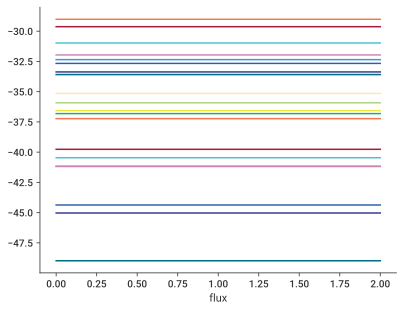

In [24]:
sweep["evals"][:,0].plot()

This result looks odd at first glance: where, for instance, is the flux-independent resonator line? The reason for the unfamiliar appearance is that we are plotting eigenvalues without subtracting the ground state energy. For that, see the `.transitions()` and `.plot_transitions()` methods below.

### Transition plots
Energy spectra obtained in single-tone or two-tone spectroscopy always represent transitions energies, rather than absolute energies of individual eigenstates. To generate data mimicking this, appropriate differences between eigenenergies must be taken.

The methods for generating transition energy data and plotting them are `<ParameterSweep>.transitions(...)` and `<ParameterSweep>.plot_transitions(...)`. To create a plot, we  use **"pre-slicing"** of the `ParameterSweep` instance to specify a sweep along a single axis, and then call `.plot_transitions()`.

.. note::
    **Pre-slicing** applies to `ParameterSweep` objects. It uses numpy or generalized slicing notation to 
    specify a subset of the sweep. For plotting, the resulting subset should be a one-dimensional sweep. Note that 
    pre-slicing does not actually discard any data. Rather, it internally marks the selected sub-sweep which is 
    then looked up when applying `.transitions()` or `plot_transitions()`.

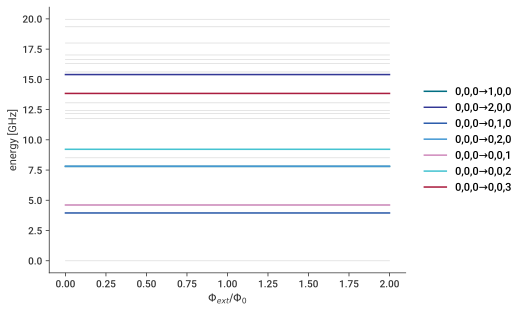

In [25]:
sweep["ng":0.0].plot_transitions();

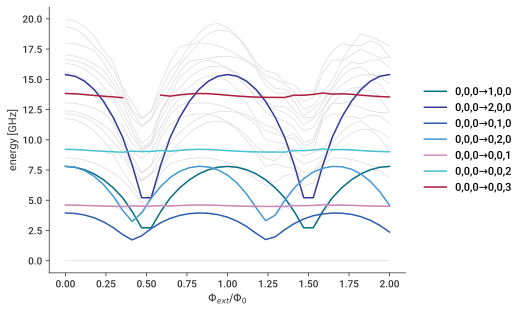

In [26]:
sweep2["ng":0.0].plot_transitions();

In [27]:
sweep.hilbertspace

HilbertSpace(**{'subsystem_list': [TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': -1.333, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), TunableTransmon(**{'EJmax': 15.0, 'EC': 0.15, 'd': 0.2, 'flux': 0.0, 'ng': 0.0, 'ncut': 30, 'truncated_dim': 3, 'id_str': 'tmon2', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': 4.5, 'l_osc': None, 'truncated_dim': 4, 'id_str': 'Oscillator_7'})], 'interaction_list': [InteractionTerm(**{'g_strength': 0.1, 'operator_list': [(0, <bound method Transmon.n_operator of TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': -1.333, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})>), (2, <bound method Oscillator.creation_operat

In [28]:
sweep2.hilbertspace

HilbertSpace(**{'subsystem_list': [TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': 0.0, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), TunableTransmon(**{'EJmax': 15.0, 'EC': 0.15, 'd': 0.2, 'flux': 0.0, 'ng': -0.5, 'ncut': 30, 'truncated_dim': 3, 'id_str': 'TunableTransmon_8', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}), Oscillator(**{'E_osc': 4.5, 'l_osc': None, 'truncated_dim': 4, 'id_str': 'Oscillator_4'})], 'interaction_list': [InteractionTerm(**{'g_strength': 0.1, 'operator_list': [(0, <bound method Transmon.n_operator of TunableTransmon(**{'EJmax': 40.0, 'EC': 0.2, 'd': 0.1, 'flux': 0.0, 'ng': 0.3, 'ncut': 40, 'truncated_dim': 3, 'id_str': 'tmon1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})>), (2, <bound method Oscillator.creation

  The generated transition plot is based on default choices:

* The origin of each transition is the system's ground state.
* Only single-photon transitions are included.
* Transitions are generally plotted in light grey. 
* By default, transitions among states of individual subsystems are marked separately and accompanied by a legend. This is possible in regions where the dispersive approximation holds, i.e., hybridization between subsystems remains weak.
* Labels in the legend are excitation levels of individual systems: ((0,0,0), (1,0,0)) denotes a transition from the ground state to the state with subsystem 1 (here: `tmon1`) in the first excited state, and subsystems 2 and 3 in their respective ground states.

One peculiarity is nearly unavoidable when coloring transitions according to the dispersive-limit state labeling: whenever states undergo avoided crossings and the dispersive limit breaks down, coloring must discontinuously switch from one branch to another. scqubits attempts to interrupt coloring in such regions. However, if the avoided crossing is so narrow that it occurs between two adjacent parameter values, then discontinuities from connecting separate branches will remain visible.

### Transition plot options
Multiple aspects of transition energy plots can be changed. The following gives a quick overview; see the API documentatation for a comprehensive discussion of options.

#### `coloring`
If ordinary coloring is preferred, this can be obtained by choosing `"plain"` coloring:

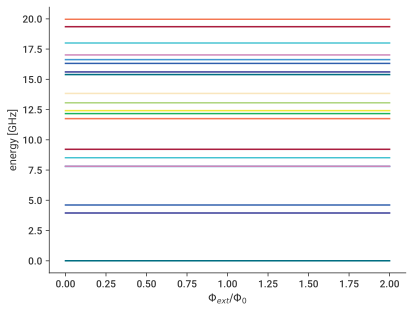

In [29]:
sweep["ng":0.0].plot_transitions(coloring="plain");

#### `subsystems`
When coloring transitions according to nature of the transition, all subsystems are included by default. If transitions for a single or smaller set of subsystem(s) should be highlighted, then these are specified in list form:

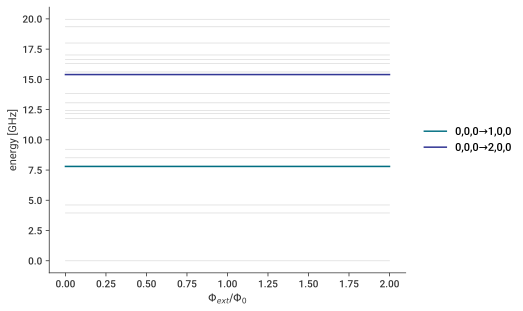

In [30]:
sweep["ng":0.0].plot_transitions(subsystems=[tmon1]);

#### `initial` and `final`
By default, the ground state is taken as origin for all transitions. In case of thermal excitations, other states can be of interest as initial states. Specification of an alternative initial state uses dispersive labeling of states:

e.g., (1,0,0) uses the 1st excited `tmon1` state as the initial state:

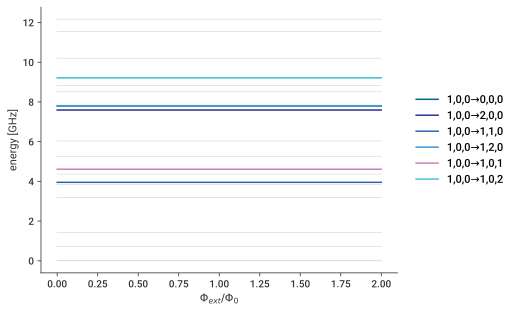

In [31]:
sweep["ng":0.0].plot_transitions(initial=(1,0,0));

Similarly `final` option may be used if only the transitions to a specific state should be highlighted:

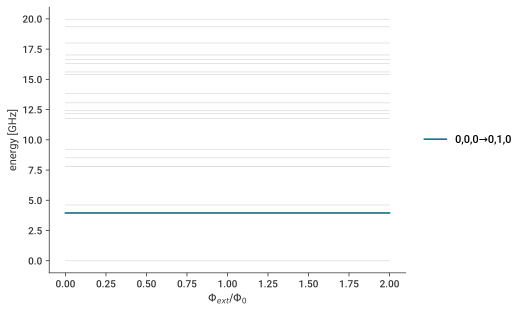

In [32]:
sweep["ng":0.0].plot_transitions(final=(0,1,0));

#### `make_positive`
When considering excited as in the previous example, some of the transition energies will naturally be negative. Experimentally, these transitions are driven at the absolute frequency. By default, absolute values of transition energies are displayed. This can be disabled by setting `make_positive=False`.


#### `sidebands`
By default, sideband transitions are not highlighted. If set to true, sideband transitions with multiple subsystems changing excitation levels are included as well:

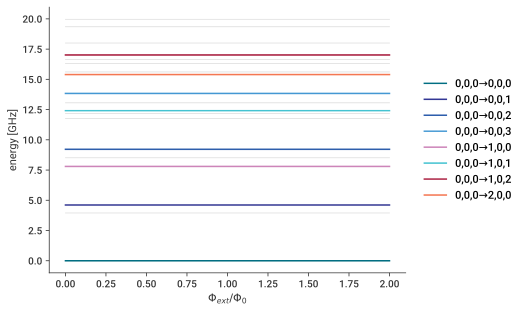

In [33]:
sweep["ng":0.0].plot_transitions(subsystems=[tmon1, resonator], sidebands=True);

### Custom sweeps
`ParameterSweep` generates data commonly needed in a multi-component quantum system. Other quantities of interest can be generated by defining a custom sweep function generating the data and calling `<ParameterSweep>.add_sweep(...)`.

To do so, define a function of the following form:

``def custom_func(paramsweep, paramindex_tuple, paramvals_tuple, **kwargs):
    ...
    return data``
    
As a toy example, here is a function that returns the 01 charge matrix element for `tmon2` at each parameter point:

In [34]:
def tmon2_n01(paramsweep, paramindex_tuple, paramvals_tuple, **kwargs):
    # We could recalculate matrix elements from scratch, but it is advantageous to use the bare spectral 
    # data we have already calculated.
    bare_evecs = sweep["bare_evecs"]["subsys":1][paramindex_tuple]
    n_matrix_elements = tmon2.matrixelement_table(
        operator="n_operator",
        evecs=bare_evecs,
        evals_count=tmon2.truncated_dim,
    )
    return np.abs(n_matrix_elements[0,1])

The `add_sweep` method takes the callable function one argument, and the name under which the scan should be stored as the second argument:

In [35]:
sweep[:].add_sweep(tmon2_n01, "n01")

sweeping tmon2_n01:   0%|          | 0/1715 [00:00<?, ?it/s]

Pre-slicing is required; here the sweep is to extend over all parameter sets associated with sweep. The resulting data is accessible by dict-like access, and yields a `NamedSlotsNdarray`:

In [36]:
sweep["n01"]

NamedSlotsNdarray([[1.30478755, 1.30478755, 1.30478755, ..., 1.30478755,
                    1.30478755, 1.30478755],
                   [1.30478755, 1.30478755, 1.30478755, ..., 1.30478755,
                    1.30478755, 1.30478755],
                   [1.30478755, 1.30478755, 1.30478755, ..., 1.30478755,
                    1.30478755, 1.30478755],
                   ...,
                   [1.30478755, 1.30478755, 1.30478755, ..., 1.30478755,
                    1.30478755, 1.30478755],
                   [1.30478755, 1.30478755, 1.30478755, ..., 1.30478755,
                    1.30478755, 1.30478755],
                   [1.30478755, 1.30478755, 1.30478755, ..., 1.30478755,
                    1.30478755, 1.30478755]])

We can easily take a slice for fixed flux and plot the result:

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='ng'>)

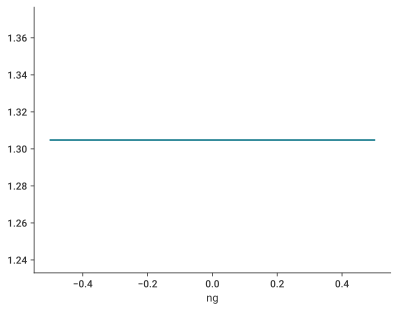

In [37]:
sweep["n01"]["flux":32].plot()

### Dispersive limit: Stark shifts and Kerr

Coupled systems of qubits and harmonic modes are frequently operated in the **dispersive regime** where relevant transition frequencies are detuned from each other and hybridization among levels can be treated perturbatively. 
An effective description of this dispersive regime involves energy corrections and dispersive couplings phrased in terms of 

* **Lamb shifts**, 
* **ac Stark shifts**, and 
* **Kerr terms**, 

to leading order. scqubits computes the associated coefficients as part of `ParameterSweep` and makes them accessible through 

* `"lamb"`:  `NamedSlotsNdarray` with axes `"subsys", <parameters>, <state label l>`
* `"chi"`:   `NamedSlotsNdarray` with axes `"subsys1", "subsys2", <parameters>, <state label l>`
* `"kerr"`:  `NamedSlotsNdarray` with axes `"subsys1", "subsys2", <parameters>, <state label l, l'>`

For instance, here are dispersive ac Stark shifts associated with `tmon1` (subsystem 0) and `resonator` (subsystem 2):

In [38]:
sweep["chi"]["subsys1":0, "subsys2":2]

NamedSlotsNdarray([[[ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    ...,
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan]],

                   [[ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    ...,
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan],
                    [ 0.        , -0.00042898, -0.00070886,         nan]],

                   [[ 0.        , -0.00042898, -0.00070886

Note that the occurence of `nan` signals that in some instances the breakdown of the dispersive approximation prevents the identification of states with bare product states. Such breakdown regions will result in "interruptions" in plots. While not visually pleasing, they do inform us that the dispersive regime is invalid in those regions and their immediate vicinity.

Simple visualization of the dispersive shift associated with level 1 (ordinarily denoted $\chi_{01}$):

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='flux'>)

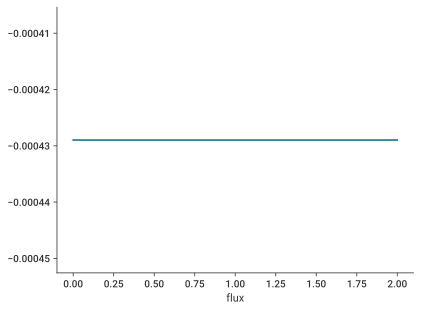

In [39]:
sweep["chi"]["subsys1":0, "subsys2":2]["ng":0][:, 1].plot()

(Interruptions again mark dispersive-limit breakdown. The unattractive "spikes" actually correspond to capturing part of the transmon's straddling regime, close to the breakdown of perturbation theory.)

Inspection of the transition spectrum matches the positions of singular behavior in $\chi$ with avoided crossings:

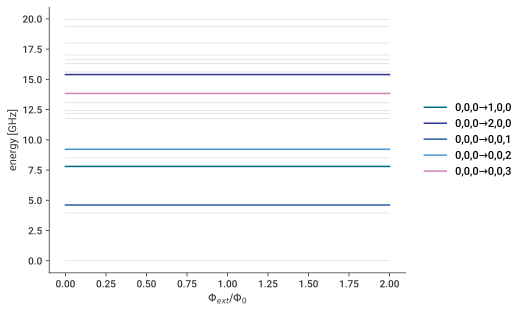

In [40]:
sweep["ng":0].plot_transitions(subsystems=[tmon1, resonator]);

Since dressed eigenenergies are used to compute these coefficients, results will not precisely agree with a 
    purely perturbative calculations stopping at finite order. For instance, the coefficients calculated here will
    not always show the divergences typical for the breakdown of perturbation theory at avoided crossings. 

### ParameterSweep helper functions

Some of the helper methods available as part of the `ParameterSweep` class (see the API documentation for more details):

`dressed_index`
    obtain the dressed index corresponding to a bare index (use pre-slicing)

In [41]:
sweep["flux":0, "ng":0].dressed_index((1,0,1))

9

`bare_index`
    obtain the bare index (bare product state label) corresponding to a dressed index (use pre-slicing)

In [42]:
sweep["flux":0, "ng":0].bare_index(8)

(0, 2, 1)

`energy_by_bare_index`
    obtain the eigenenergy for given bare index (use pre-slicing)

In [43]:
sweep["ng":0].energy_by_bare_index((1,1,0))

NamedSlotsNdarray([-37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793, -37.22784793,
                   -37.22784793, -37.22784793, -37.22784793])